# Importing Data and Packages #

In [20]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [21]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from precision_recall_cutoff import precision_recall_cutoff

from tqdm import tqdm
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier 
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, recall_score
from sklearn.feature_selection import RFE, RFECV

pd.set_option('display.max_columns', 50)

store_final = pd.read_csv('store_final.csv')
store_final.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Income_imp,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Widow,Age,Child,MntTotal,Recency_u50,TotalPurchses,Enr_year,Enr_quarter,Enr_month,Log_Income,Interaction_1,Interaction_2,Interaction_3,Interaction_4,Interaction_5,Interaction_6,Tree_1,Tree_2,Tree_3,Response
0,1970,84835.0,0,0,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,1,0,0,1,0,0,0,53,0,1190,1,14,2014,2,6,11.348463,259420,4760,0,872,0,0,0,0,0,1
1,1961,57091.0,0,0,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,1,0,0,0,0,1,0,62,0,577,1,17,2014,2,6,10.952402,21349,1731,0,111,0,0,0,1,0,1
2,1958,67267.0,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,1,0,0,0,1,0,0,65,1,251,1,10,2014,2,5,11.116425,7530,502,0,60,0,0,0,1,0,0
3,1967,32474.0,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,1,0,0,0,1,0,0,56,1,11,1,3,2014,4,11,10.388195,0,0,0,0,0,0,0,1,0,0
4,1989,21474.0,1,0,0,6,16,24,11,0,34,2,3,1,2,7,0,0,0,1,0,0,0,0,1,0,34,1,91,1,6,2014,3,8,9.974598,3094,91,0,34,0,0,0,1,0,1


In [23]:
#defining input (top 8) and target (Response)
x=store_final[['Recency', 'MntTotal', 'Interaction_2', 'Enr_year', 'MntWines', 'Interaction_4', 'MntMeatProducts', 'NumWebVisitsMonth']]
y=store_final['Response']

#splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

#creating the train and test data-frames
train = pd.concat([x_train, y_train], axis = 1).reset_index(drop = True)
test = pd.concat([x_test, y_test], axis = 1).reset_index(drop = True)

## Predictive Modeling ##

**Initial Modeling**

*Evaluating results on validation data*

In [29]:
#store model results
dt_results = []
rf_results = []
ada_results = []
gb_results = []
xgb_results = []

x=train[['Recency', 'MntTotal', 'Interaction_2', 'Enr_year', 'MntWines', 'Interaction_4', 'MntMeatProducts', 'NumWebVisitsMonth']]
y=train['Response']

for i in tqdm(range(0,100)):
    
    #splitting the data
    x_training,x_valid,y_training,y_valid = train_test_split(x,y,test_size=0.2,stratify=y)
    
    #top 6 variables for RF model
    x_training_6 = x_training.drop(columns = ['MntMeatProducts','NumWebVisitsMonth'])
    x_valid_6 = x_valid.drop(columns = ['MntMeatProducts','NumWebVisitsMonth'])
    
    ######### Decision Tree ######### 
    
    #building the model with best hyperparameters
    dt_md = DecisionTreeClassifier(min_samples_split = 10, min_samples_leaf = 5, max_depth = 7).fit(x_training, y_training)

    #predicting on test & validation
    dt_pred_v = dt_md.predict_proba(x_valid)[:,1]

    #changing likelihood to labels
    dt_label = precision_recall_cutoff(y_valid, dt_pred_v)
    
    dt_results.append(recall_score(y_valid, dt_label))
    
    ######### Random Forest ######### 
    
    #building the model with best hyperparameters
    rf_md = RandomForestClassifier(max_depth = 7, min_samples_leaf = 5, min_samples_split = 10, n_estimators = 300).fit(x_training_6,y_training)

    #predicting on test & validation
    rf_pred_v = rf_md.predict_proba(x_valid_6)[:,1]

    #changing likelihood to labels
    rf_label = precision_recall_cutoff(y_valid, rf_pred_v)
    
    rf_results.append(recall_score(y_valid, rf_label))
    
    ######### AdaBoost ######### 
    
    #building the model with best hyperparameters
    ada_md = AdaBoostClassifier(estimator = DecisionTreeClassifier(min_samples_split = 10, min_samples_leaf = 7, max_depth = 3),
                            n_estimators = 300, learning_rate = 0.1).fit(x_training, y_training)

    #predicting on test  & validation
    ada_pred_v = ada_md.predict_proba(x_valid)[:,1]

    #changing likelihood to labels
    ada_label = precision_recall_cutoff(y_valid, ada_pred_v)
    
    ada_results.append(recall_score(y_valid, ada_label))
    
    ######### Gradient Boosting ######### 
    
    #building the model with best hyperparameters
    gb_md = GradientBoostingClassifier(max_depth = 7, min_samples_leaf = 5, min_samples_split = 10, 
                                       learning_rate = 0.1, n_estimators = 100).fit(x_training, y_training)

    #predicting on test & validation
    gb_pred_v = gb_md.predict_proba(x_valid)[:,1]

    #changing likelihood to labels
    gb_label = precision_recall_cutoff(y_valid, gb_pred_v)

    gb_results.append(recall_score(y_valid, gb_label))
    
    ######### XGBoost ######### 
    
    #building the model with best hyperparameters
    xgb_md = XGBClassifier(n_estimators = 500, learning_rate = 0.1, max_depth = 7, gamma = 0.1, 
                           min_child_weight = 5, subsample = 0.8, colsample_bytree = 1).fit(x_training, y_training)

    #predicting on test & validation
    xgb_pred_v = xgb_md.predict_proba(x_valid)[:,1]

    #changing likelihood to labels
    xgb_label = precision_recall_cutoff(y_valid, xgb_pred_v)
    
    xgb_results.append(recall_score(y_valid, xgb_label))
    
print('dt',np.mean(dt_results))
print('rf',np.mean(rf_results))
print('ada',np.mean(ada_results))
print('gb',np.mean(gb_results))
print('xgb',np.mean(xgb_results))

100%|██████████| 100/100 [07:15<00:00,  4.35s/it]

dt 0.902295081967213
rf 0.8858360655737705
ada 0.9616065573770493
gb 0.9621967213114757
xgb 0.9604590163934426


In [30]:
#initial dictionary of data
data = {'Model':['DT', 'RF', 'ADA', 'GB', 'XGB'], 
        'Avg Recall':[np.mean(dt_results), np.mean(rf_results), np.mean(ada_results), np.mean(gb_results), np.mean(xgb_results)]}

#data frame
model_eval = pd.DataFrame(data)
model_eval = model_eval.sort_values(by='Avg Recall', ascending = False).reset_index(drop = True)

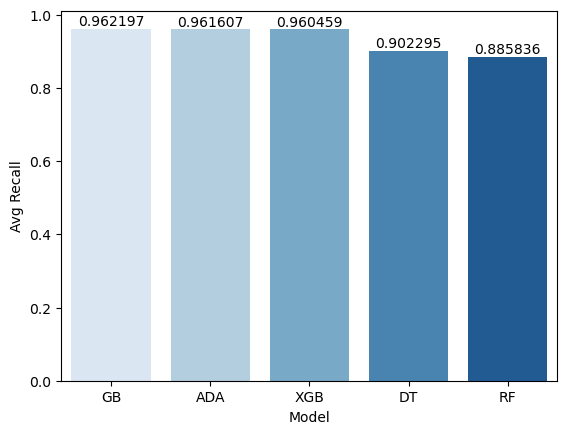

In [31]:
ax = sns.barplot(x='Model', y='Avg Recall', data=model_eval, palette = 'Blues')
for i in ax.containers:
    ax.bar_label(i,)

Top 3 models are very clearly the Gradient Boosting, XGBoost, and AdaBoost models. 

 - In the next phase of modeling, 
     - an ensemble of the top three models will be included in the evaluation process. 
     - an ensemble of the five models will also be included in the evaluation process.
     
 The ensemble methods will take the predictions of the models as inputs and potentially boost prediction power. 

**Final Modeling w/ Ensemble Methods**

In [36]:
#store model results
dt_results = []
rf_results = []
ada_results = []
gb_results = []
xgb_results = []
ens3_results = []
ens5_results = []

x=train[['Recency', 'MntTotal', 'Interaction_2', 'Enr_year', 'MntWines', 'Interaction_4', 'MntMeatProducts', 'NumWebVisitsMonth']]
y=train['Response']

x_test = test[['Recency', 'MntTotal', 'Interaction_2', 'Enr_year', 'MntWines', 'Interaction_4', 'MntMeatProducts', 'NumWebVisitsMonth']]
y_test = test['Response']

for i in tqdm(range(0,100)):
    
    #splitting the data
    x_training,x_valid,y_training,y_valid = train_test_split(x,y,test_size=0.2,stratify=y)
    
    #top 6 variables for RF model
    x_training_6 = x_training.drop(columns = ['MntMeatProducts','NumWebVisitsMonth'])
    x_valid_6 = x_valid.drop(columns = ['MntMeatProducts','NumWebVisitsMonth'])
    x_test_6 = x_test.drop(columns = ['MntMeatProducts','NumWebVisitsMonth'])
    
    ######### Decision Tree ######### 
    
    #building the model with best hyperparameters
    dt_md = DecisionTreeClassifier(min_samples_split = 10, min_samples_leaf = 5, max_depth = 7).fit(x_training, y_training)

    #predicting on test & validation
    dt_pred_v = dt_md.predict_proba(x_valid)[:,1]
    dt_pred_t = dt_md.predict_proba(x_test)[:,1]

    #changing likelihood to labels
    dt_label = precision_recall_cutoff(y_test, dt_pred_t)
    
    dt_results.append(recall_score(y_test, dt_label))
    
    ######### Random Forest ######### 
    
    #building the model with best hyperparameters
    rf_md = RandomForestClassifier(max_depth = 7, min_samples_leaf = 5, min_samples_split = 10, n_estimators = 300).fit(x_training_6,y_training)

    #predicting on test & validation
    rf_pred_v = rf_md.predict_proba(x_valid_6)[:,1]
    rf_pred_t = rf_md.predict_proba(x_test_6)[:,1]
    
    #changing likelihood to labels
    rf_label = precision_recall_cutoff(y_test, rf_pred_t)
    
    rf_results.append(recall_score(y_test, rf_label))
    
    ######### AdaBoost ######### 
    
    #building the model with best hyperparameters
    ada_md = AdaBoostClassifier(estimator = DecisionTreeClassifier(min_samples_split = 10, min_samples_leaf = 7, max_depth = 3),
                            n_estimators = 300, learning_rate = 0.1).fit(x_training, y_training)

    #predicting on test  & validation
    ada_pred_v = ada_md.predict_proba(x_valid)[:,1]
    ada_pred_t = ada_md.predict_proba(x_test)[:,1]
    
    #changing likelihood to labels
    ada_label = precision_recall_cutoff(y_test, ada_pred_t)
    
    ada_results.append(recall_score(y_test, ada_label))
    
    ######### Gradient Boosting ######### 
    
    #building the model with best hyperparameters
    gb_md = GradientBoostingClassifier(max_depth = 7, min_samples_leaf = 5, min_samples_split = 10, 
                                       learning_rate = 0.1, n_estimators = 100).fit(x_training, y_training)

    #predicting on test & validation
    gb_pred_v = gb_md.predict_proba(x_valid)[:,1]
    gb_pred_t = gb_md.predict_proba(x_test)[:,1]

    #changing likelihood to labels
    gb_label = precision_recall_cutoff(y_test, gb_pred_t)

    gb_results.append(recall_score(y_test, gb_label))
    
    ######### XGBoost ######### 
    
    #building the model with best hyperparameters
    xgb_md = XGBClassifier(n_estimators = 500, learning_rate = 0.1, max_depth = 7, gamma = 0.1, 
                           min_child_weight = 5, subsample = 0.8, colsample_bytree = 1).fit(x_training, y_training)

    #predicting on test & validation
    xgb_pred_v = xgb_md.predict_proba(x_valid)[:,1]
    xgb_pred_t = xgb_md.predict_proba(x_test)[:,1]

    #changing likelihood to labels
    xgb_label = precision_recall_cutoff(y_test, xgb_pred_t)
    
    xgb_results.append(recall_score(y_test, xgb_label))
    
    ######### Top 3 Ensemble #########
    x_v_ensemble3 = pd.concat([pd.DataFrame(gb_pred_v),pd.DataFrame(ada_pred_v),pd.DataFrame(xgb_pred_v)], axis = 1)
    x_t_ensemble3 = pd.concat([pd.DataFrame(gb_pred_t),pd.DataFrame(ada_pred_t),pd.DataFrame(xgb_pred_t)], axis = 1)
    
    ens3_md = RandomForestClassifier(max_depth = 7, min_samples_leaf = 5, min_samples_split = 10, 
                                     n_estimators = 300).fit(x_v_ensemble3,y_valid)

    #predicting on test
    ens3_pred_t = ens3_md.predict_proba(x_t_ensemble3)[:,1]
    
    #changing likelihood to labels
    ens3_label = precision_recall_cutoff(y_test, ens3_pred_t)
    
    ens3_results.append(recall_score(y_test, ens3_label))
    
    ######### Top 5 Ensemble #########
    x_v_ensemble5 = pd.concat([pd.DataFrame(gb_pred_v),pd.DataFrame(ada_pred_v),pd.DataFrame(xgb_pred_v),
                              pd.DataFrame(dt_pred_v),pd.DataFrame(rf_pred_v)], axis = 1)
    x_t_ensemble5 = pd.concat([pd.DataFrame(gb_pred_t),pd.DataFrame(ada_pred_t),pd.DataFrame(xgb_pred_t),
                              pd.DataFrame(dt_pred_t),pd.DataFrame(rf_pred_t)], axis = 1)
    
    ens5_md = RandomForestClassifier(max_depth = 7, min_samples_leaf = 5, min_samples_split = 10, 
                                     n_estimators = 300).fit(x_v_ensemble5,y_valid)

    #predicting on test
    ens5_pred_t = ens5_md.predict_proba(x_t_ensemble5)[:,1]
    
    #changing likelihood to labels
    ens5_label = precision_recall_cutoff(y_test, ens5_pred_t)
    
    ens5_results.append(recall_score(y_test, ens5_label))
    
    
print('dt',np.mean(dt_results))
print('rf',np.mean(rf_results))
print('ada',np.mean(ada_results))
print('gb',np.mean(gb_results))
print('xgb',np.mean(xgb_results))
print('ens_3',np.mean(ens3_results))
print('ens_5',np.mean(ens5_results))

100%|██████████| 100/100 [09:49<00:00,  5.89s/it]

dt 0.8854973821989529
rf 0.8510471204188482
ada 0.9645811518324607
gb 0.961282722513089
xgb 0.9606282722513089
ens_3 0.965785340314136
ens_5 0.9685340314136126


In [37]:
#initial dictionary of data
data = {'Model':['DT', 'RF', 'ADA', 'GB', 'XGB', 'ENS_3', 'ENS_5'], 
        'Avg Recall':[np.mean(dt_results), np.mean(rf_results), np.mean(ada_results), np.mean(gb_results), np.mean(xgb_results),
                     np.mean(ens3_results), np.mean(ens5_results)]}

#data frame
model_eval = pd.DataFrame(data)
model_eval = model_eval.sort_values(by='Avg Recall', ascending = False).reset_index(drop = True)

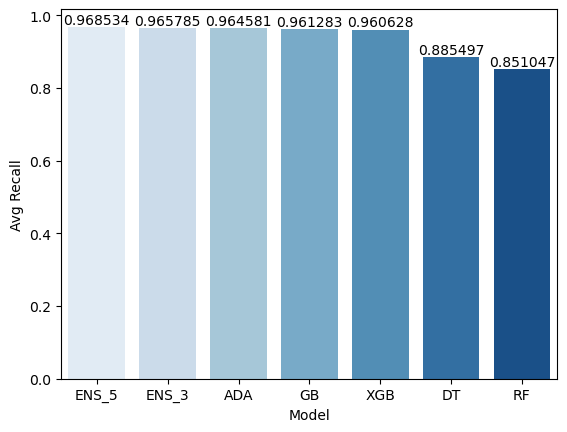

In [38]:
ax = sns.barplot(x='Model', y='Avg Recall', data=model_eval, palette = 'Blues')
for i in ax.containers:
    ax.bar_label(i,)